In [44]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from sklearn.model_selection import train_test_split

In [45]:
dataTrain = pd.read_csv('./data/twitter_train.csv')
dataTrain.columns = ["tweet id", "entity", "sentiment", "content"]
dataTrain.drop(["tweet id", "entity"],inplace=True, axis=1)

dataTrain.head()

,sentiment,content
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [46]:
dataTrain.isnull().sum()

sentiment      0
content      686
dtype: int64

In [47]:
dataTrain.dropna(inplace=True)

In [48]:
dataTrain.isnull().sum()

sentiment    0
content      0
dtype: int64

In [49]:
dataTrain["sentiment"].value_counts()

sentiment
Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

In [50]:
dataTrain = dataTrain[dataTrain.sentiment != "Irrelevant"]

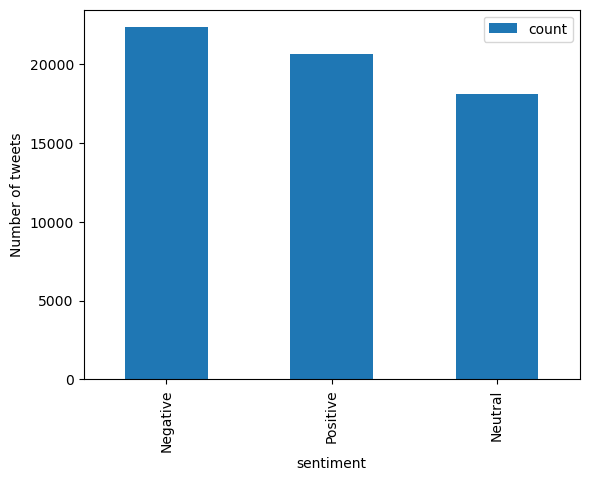

In [51]:
distr = dataTrain["sentiment"].value_counts()
plot = distr.plot(kind="bar")
plot.set_ylabel('Number of tweets')
plot.legend()
plt.show()

In [52]:
dataTrain['content'] = dataTrain['content'].apply(lambda x: x.lower())
dataTrain['content'] = dataTrain['content'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(dataTrain[ dataTrain['sentiment'] == 'Positive'].size)
print(dataTrain[ dataTrain['sentiment'] == 'Neutral'].size)
print(dataTrain[ dataTrain['sentiment'] == 'Negative'].size)

for idx,row in dataTrain.iterrows():
    row.iloc[0] = row.iloc[0].replace('rt',' ')
    
maxFeatures = 2000
tokenizer = Tokenizer(num_words=maxFeatures, split=' ')
tokenizer.fit_on_texts(dataTrain['content'].values)
X = tokenizer.texts_to_sequences(dataTrain['content'].values)
X = pad_sequences(X)

41308
36216
44716


In [53]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Input(shape=(X.shape[1],)))
model.add(Embedding(2000, embed_dim))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 166, 128)          256000    
                                                                 
 spatial_dropout1d_3 (Spati  (None, 166, 128)          0         
 alDropout1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 196)               254800    
                                                                 
 dense_3 (Dense)             (None, 3)                 591       
                                                                 
Total params: 511391 (1.95 MB)
Trainable params: 511391 (1.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [54]:
Y = pd.get_dummies(dataTrain['sentiment']).values
print(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

[[False False  True]
 [False False  True]
 [False False  True]
 ...
 [False False  True]
 [False False  True]
 [False False  True]]
(48896, 166) (48896, 3)
(12224, 166) (12224, 3)


In [55]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10


KeyboardInterrupt: 

In [57]:
# Variables to count instances and correct predictions
pos_cnt, neg_cnt, neut_cnt = 0, 0, 0
pos_correct, neg_correct, neut_correct = 0, 0, 0

for x in range(len(X_test)):
    result = model.predict(X_test[x].reshape(1, X_test.shape[1]), batch_size=1, verbose=1)[0]
    
    predicted_class = np.argmax(result)
    true_class = np.argmax(Y_test[x])
    
    # Check if prediction is correct
    if predicted_class == true_class:
        if true_class == 0:
            neg_correct += 1
        elif true_class == 1:
            neut_correct += 1
        elif true_class == 2:
            pos_correct += 1
    
    # Increment the respective counters
    if true_class == 0:
        neg_cnt += 1
    elif true_class == 1:
        neut_cnt += 1
    elif true_class == 2:
        pos_cnt += 1

# Calculate and print accuracies
print("pos_acc:", pos_correct / pos_cnt * 100, "%")
print("neg_acc:", neg_correct / neg_cnt * 100, "%")
print("neut_acc:", neut_correct / neut_cnt * 100, "%")

1/1 [==============================] - 0s 284ms/step


KeyboardInterrupt: 